In [1]:
#pip install -U imbalanced-learn

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np 
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay

from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.under_sampling import NearMiss

import warnings

# Filter and ignore the specific FutureWarnings from LinearSVC
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.svm._classes")

Lets first read the csv we just downloaded from kaggle 

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
len(df)

284807

Now lets define our target column and our feature columns. We will not go into great detail analyzing what each column represent since our main goal is to handle the imbalance of the datasets. As described in kaggle our dataset contains in total 284.807 rows each row representing a transaction. From these transaction only 492 are fraudelant transactions. If we tried to handle this as a normal dataset we could end up with a model that has an accuracy of 99% just because it predicts always that a transaction is not fraudelant. 

In [6]:
y = df["Class"]

In [7]:
unique_classes, class_counts = np.unique(y, return_counts=True)

In [8]:
unique_classes

array([0, 1])

In [9]:
class_counts

array([284315,    492])

Class 0 - non fraud transaction  
Class 1 - fraud transaction

In [10]:
x = df.drop(["Class"],axis=1)

In the cells below we create three lists, one that contains the names of the classifiers and two that contain the classifiers themselves. The difference between clf1 and clf2 is that the second one has the class_weight parameter set to balanced in order to help with the dataset imbalance.

In [11]:
names = ["RandomForestClassifier","LinearSVC","GaussianNB"]
names_weight_aware = ["RandomForestClassifier","LinearSVC"]
clf1 = [RandomForestClassifier(),LinearSVC(),GaussianNB()]
clf2 = [RandomForestClassifier(class_weight="balanced"),LinearSVC(class_weight="balanced")]

Before actually trying to train our models to the data lets consider of how we could better asses their performance. Would it be wise to just use accuracy? As we already explained above this would lead to a fictional high accuracy even if the classifier would always predict class 0. For this reason we will also utilice "balanced_accuracy" as a metric. Balanced accuracy takes into consideration the number of instances in a class as opposed to "accuracy"

In [12]:
scoring = ['accuracy', 'balanced_accuracy']


In [13]:
x

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


Now lets try to train and and see how the standart classifiers we defined above handle the challenge. We zip the list of names with the list of the default modes in order to be able to automate the process. For getting more accurate results about out models performance we will use cross_validate. By print the mean and standart deviation of the metrics we get a better understanding to how our models performed. Remember that cross validation with cv=10 train 10 times with each time appending a different tenth of the whole dataset as the test set. Then we train the models and display the Roc curve.

RandomForestClassifier - default without specialized class weights parameter


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  3.2min remaining: 12.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.5min finished


accuracy : 0.9166391576495506 , 0.24838562169798564 
balanced_accuracy : 0.8323841794636755 , 0.10861388492126108 
LinearSVC - default without specialized class weights parameter


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/georgeasvestopoulos/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/georgeasvestopoulos/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/georgeasvestopoulos/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/georgeasvestopoulos/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change 

accuracy : 0.9983146477949619 , 0.00036925327653554777 
balanced_accuracy : 0.5386481544221515 , 0.06689558255652918 


/Users/georgeasvestopoulos/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


GaussianNB - default without specialized class weights parameter


[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished


accuracy : 0.9926406325141264 , 0.0011721173181162702 
balanced_accuracy : 0.8165640000391295 , 0.09663487236505987 


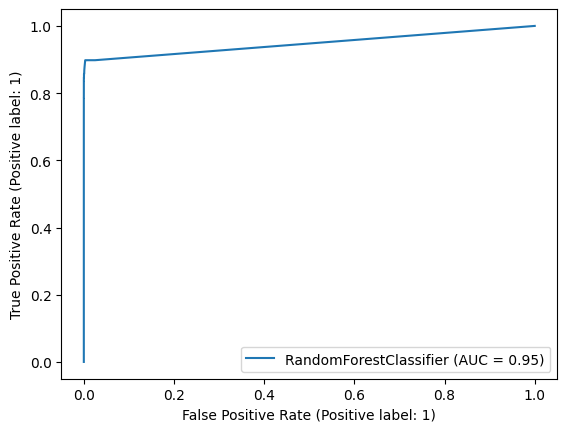

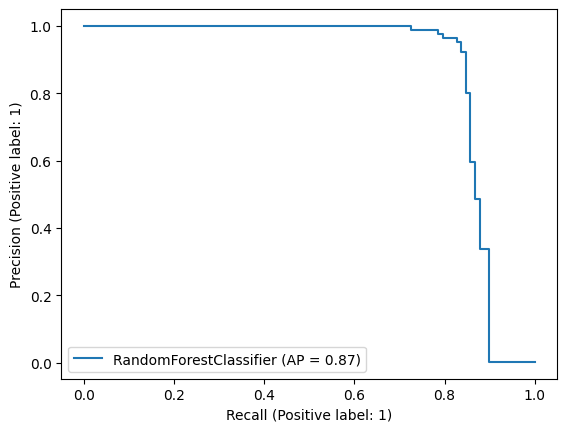

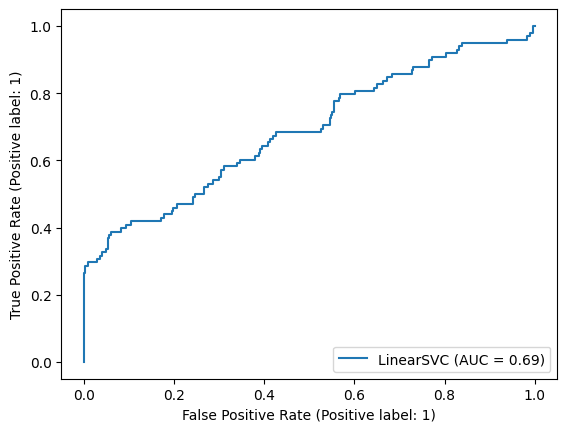

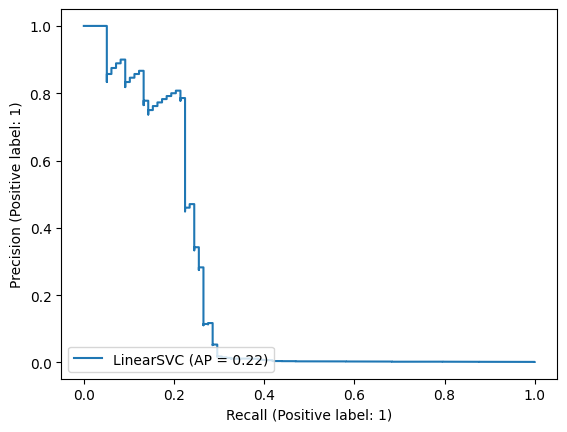

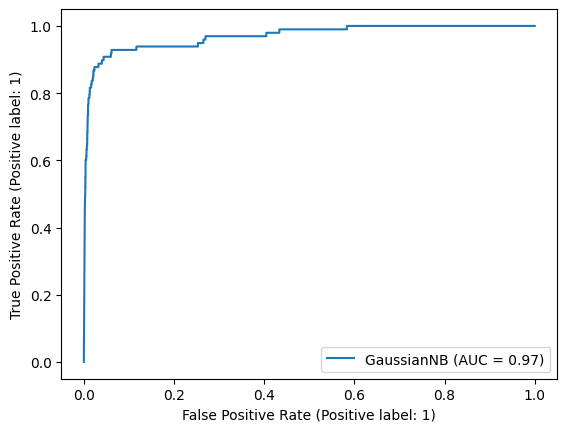

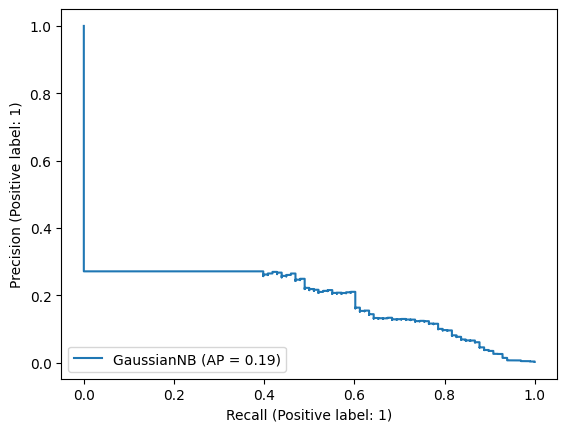

In [15]:

store_predictions = {}

for name, clf in zip(names,clf1):
    print(f"{name} - default without specialized class weights parameter")
    scores = cross_validate(clf,x,y,scoring= scoring ,cv= 10, return_train_score = False,verbose = 1 ,  n_jobs = -1)
    
    for score in scoring:
        print(f"{score} : {scores['test_'+score].mean()} , {scores['test_'+score].std()} ")
    
    clf.fit(x_train,y_train)
    
    key = name + "_default"

    store_predictions[key] = clf.predict(x_test)
    
    RocCurveDisplay.from_estimator(clf, x_test, y_test)
    PrecisionRecallDisplay.from_estimator(clf, x_test, y_test)
    

Lets discuss the results. Comparing the different classifiers with their respective metrics we can deduct that classifiers that performed the best were Random Forest and GaussianNB. The accuracy for these 2 is nearly 100% which is misleading and thats the reason balanced accuracy is used. It is evident that the worst model is LinearSVC because its a linear model and cannot create proper borders to seperate the different classes. Balanced accuracy is nearly 0.5 which makes the predictions almost random for the minority class. Now as for the ROC curves, it's obvious that the ROC curves for Random Forest and GaussianNB are too good to be true since these kind of curves are a textbook perfect curve. Contrary to these curves, LinearSVC ROC curve is almos a diagonal line which is the worst case scenario we want from a classifier. Our first classifier, RandomForest, has an Average Precision of 0.82 and this means that this classifier can perform very well without the need for the class_weight parameter. LinearSVC has AP=0.05 which is not the best result and we can conclude that is not a good classifier in this case. Finally, GaussianNB has AP=0.15, this means that from 100 cases classified as 1 only 15 were correct. This means that the classifier found most of the class 1 cases correcltly (balanced accuracy is high) but missclassified a lot of zero class instances as class one instances which is depicted through its poor average precision score. 

Now lets perform the same for the models that are agnostic of the class imbalance in order to see if we get better results.

    

RandomForestClassifier - imbalance aware


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  1.7min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.0min finished


accuracy : 0.9993399052699828 , 0.0003555752282780585 
balanced_accuracy : 0.8566112237078455 , 0.062400639069399466 
LinearSVC - imbalance aware


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/georgeasvestopoulos/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/georgeasvestopoulos/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/georgeasvestopoulos/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/georgeasvestopoulos/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change 

accuracy : 0.9984164700624385 , 0.0005293449538732789 
balanced_accuracy : 0.5686055794518869 , 0.1287562007769248 


/Users/georgeasvestopoulos/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


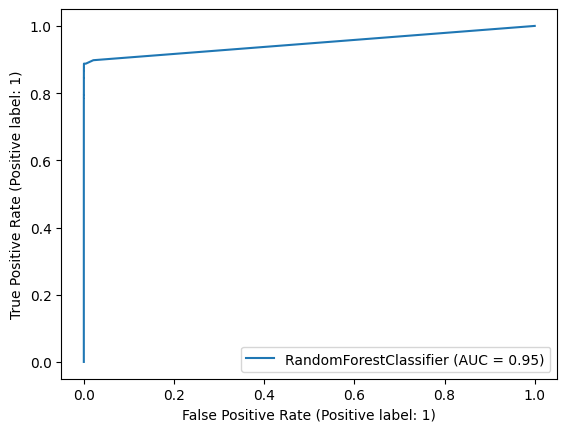

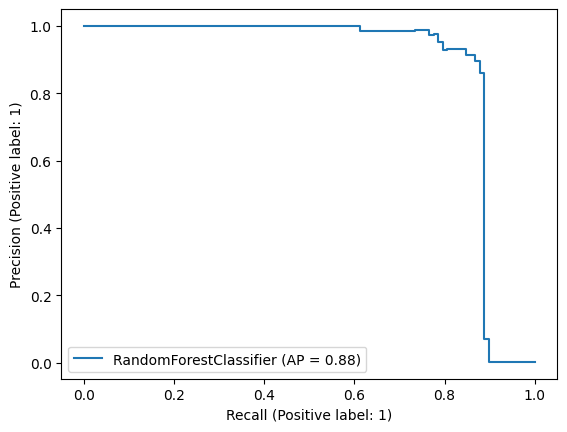

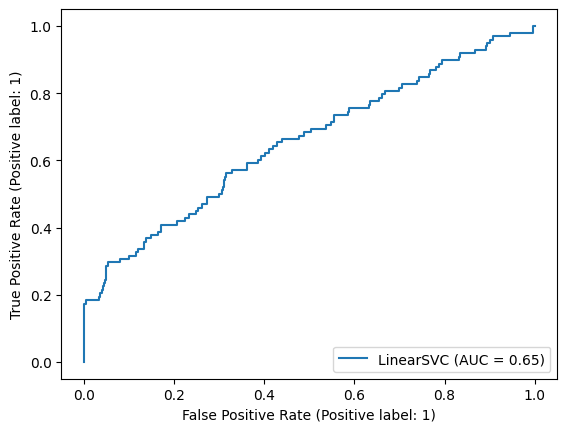

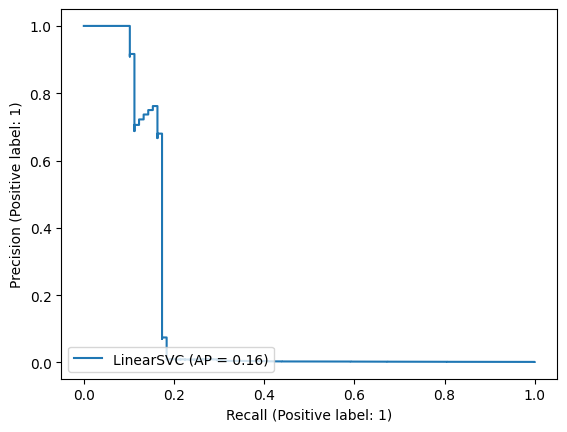

In [16]:
for name, clf in zip(names_weight_aware,clf2):
    print(f"{name} - imbalance aware")
    scores = cross_validate(clf,x,y,scoring= scoring ,cv= 10, return_train_score = False,verbose = 1 ,  n_jobs = -1)
    
    for score in scoring:
        print(f"{score} : {scores['test_'+score].mean()} , {scores['test_'+score].std()} ")
    
    clf.fit(x_train,y_train)
    
    key = name + "_imbalance_aware"

    store_predictions[key] = clf.predict(x_test)
    
    RocCurveDisplay.from_estimator(clf, x_test, y_test)
    PrecisionRecallDisplay.from_estimator(clf, x_test, y_test)

The results are almost similar. Random Forest had a slight increase in balanced accuracy, but since it was already a good classifier it cannot be considered as a significant result. LinearSVC had a its AP doubled from 0.05 to 0.10 but still its a low number to be considered a good model. Lastly, GaussianNB doesn't have the class_weight parameter.
Someone could argue that the balanced 84% accuracy of the random classifier is good enough. But lets not compromise and see which model is the best for our use case. 
The first model we will explore is the EasyEnsemble classifier from the imblearn library. The EasyEnsembleClassier randomly samples with replacement from the majority class as many examples as the minority class. By doing so the class imbalance problem is mitigated since there now as many instances from the minority class as there are from the majority. We will again train and present the results of all models in order to get our results summarized. 

Next lets review investigate another technique commonly used in class imbalance problems, namely SMOTE. Smote is a technique which utilizes the existent instances of the minority class in order to create more fictional instances and thus make the difference in numbers a bit less. But how exactly does Smote do this. Lets discuss how the Smote algorithm works in steps. 

1)SMOTE begins by identifying the minority class in the dataset, which has fewer examples than the majority class.

2)For each instance in the minority class, SMOTE selects its k-nearest neighbors in the feature space. The value of 'k' can be specified by us within the code. You can visualize this by imagining all instances in a 2-D space, where proximity between instances is based on the similarity of their feature values. If you want a detailed understanding of how SMOTE works, I recommend watching a video tutorial, as visualizing the procedure can be very helpful. If you'd like more theory-based tutorials in the future, please let me know. However, our current focus is on writing the actual code, so we won't delve extensively into the theory of SMOTE here.

3)SMOTE then creates synthetic instances for each selected minority class example by interpolating between the feature vectors of the chosen instance and one or more of its neighbors. By utilizing both the instances and a neighbours feature vector, Smote creates a third new instance that resambles the 2 real ones. 

4)The synthetic instances are added to the minority class, increasing its size and balancing the class distribution.

In order to utilize Smote and see its effect in a models accuracy we will use it in combination with the random forest classifier that we have already used. We will also train random forest without smote and with the class weighting parameter enabled in order to compare the results. Lastly Smote can be incorporated in the process by creating a pipeline and setting smote as the first step of it and the model as the second step. Then we will call fit on the pipeline itself. By doing so our data. will first be updated by SMOTE and then passed to the nexr step of the pipeline, namely out main classifier. For assesing our models performance we will use the classification_report_imbalanced from the imblearn library in order to investigate another way of assesing such a models performance. 

In [17]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

In [18]:

print("Random Forest")
#pipeline = make_pipeline(clf1[0])
#pipeline.fit(X_train, y_train)
key = names[0] + "_default"

print(classification_report_imbalanced(y_test, store_predictions[key]))

print("Same model but with class weighting")

#pipeline = make_pipeline(clf2[0])
#pipeline.fit(x_train, y_train)
key = names[0]  + "_imbalance_aware"


print(classification_report_imbalanced(y_test, store_predictions[key]))


print("Same model but with SMOTE implemented")

# Create a pipeline
pipeline = make_pipeline(SMOTE(random_state=3, k_neighbors=6),
                         clf1[0])
pipeline.fit(x_train, y_train)

# Classify and report the results
print(classification_report_imbalanced(y_test, pipeline.predict(x_test)))

Random Forest
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.79      1.00      0.89      0.80     56864
          1       0.99      0.79      1.00      0.88      0.89      0.77        98

avg / total       1.00      1.00      0.79      1.00      0.89      0.80     56962

Same model but with class weighting
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.73      1.00      0.86      0.75     56864
          1       0.99      0.73      1.00      0.84      0.86      0.72        98

avg / total       1.00      1.00      0.74      1.00      0.86      0.75     56962

Same model but with SMOTE implemented
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.84      1.00      0.91      0.85     56864
          1       0.86      0.84      1.00      0.85      0.91      0.82   

In the case of Random Forest we observe that SMOTE gives a little worse percision for the minority class (0.92) in comparison to normal random forest and the one with the class weight parameter(0.95 and 0.96 respectively). This could lead us into believing that our model has become worse. But lets thing here for a moment. Is precission the right metric to take into account when talking about the minority class ? 
The short answer is no. But why ?

Remember precission is equal to TP/(TP+FP) whereas recall is 
equal to TP/(TP+FN).

Where TP = True positives, FP = False positives, FN = False negatives. ( if you are not familiar with these metrics i woulds higly reccomend you to read an article about them since knowing when to use each one is crucial )

In other words Precision answers the question: "Of all the instances that the model predicted as Fraud transactions, how many were actually fraud transaction?"

Whereas Recall answers the question:"Of all the actual positive Fraud transactions, how many did our model correctly predict?"

Simple stated, recall expresses our models performance regarding the minority class by taking into account all of the instances of the minority class whereass precision doesn't. 

And if we see the recall that we got when using SMOTE we quickly understand that our models performace got better regarding the minority class which is in our case the most important class. It is better to correctly identify more fraudelant transaction and make more mistakes in the way. The mistakes we make are the false positives, namely the instances that are not fraudelant but we identify as such. These false positives are in the denominator of the precission calculation and that is the reason precission worsens when recall gets higher.

But the random classifier was already a good enough model. Lets see how a weak model like the Linear SVC benefits from the usage of SMOTE. The results will surprise you 






In [19]:
print("LINEAR SVC")

#pipeline = make_pipeline(clf1[1])
#pipeline.fit(x_train, y_train)

key = names[1] + "_default"


print(classification_report_imbalanced(y_test, store_predictions[key]))

print("Same model but with class weighting")

#pipeline = make_pipeline(clf2[1])
#pipeline.fit(X_train, y_train)

key = names[1]  + "_imbalance_aware"

print(classification_report_imbalanced(y_test, store_predictions[key]))


print("Same model but with SMOTE implemented")

# Create a pipeline
pipeline = make_pipeline(SMOTE(random_state=3, k_neighbors=6),
                         clf1[1])
pipeline.fit(x_train, y_train)

# Classify and report the results
print(classification_report_imbalanced(y_test, pipeline.predict(x_test)))


LINEAR SVC
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.22      1.00      0.47      0.24     56864
          1       0.61      0.22      1.00      0.33      0.47      0.21        98

avg / total       1.00      1.00      0.23      1.00      0.47      0.24     56962

Same model but with class weighting
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.16      1.00      0.40      0.18     56864
          1       0.70      0.16      1.00      0.26      0.40      0.15        98

avg / total       1.00      1.00      0.16      1.00      0.40      0.18     56962

Same model but with SMOTE implemented
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      0.83      0.99      0.90      0.82     56864
          1       0.07      0.83      0.98      0.13      0.90      0.80      

/Users/georgeasvestopoulos/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The results here are remarkable better with SMOTE compared to without SMOTE. The recall for the minority class has skyrocketed from to . This means that 76% of the instances were correctly classified. Precision is still low for class 1, which means that a lot of class 0 instances were classified as class 1 instances which is ok in our case since our important class is 1.  

Last but not least lets explore the near-miss technique. in contrast to SMOTE Near-Miss is a family of techniques that address class imbalance by undersampling the majority class, removing some instances to balance the dataset. There are three versions of Near-Miss:
Near Miss-1: It removes majority class instances close to the minority class, keeping only those farthest from the minority class to reduce confusion.

Near Miss-2: This version retains majority class instances with the smallest average distance to the k-nearest minority class instances, making it challenging for the model to misclassify them.

Near Miss-3: Unlike the first two, Near Miss-3 removes majority class instances far from the decision boundary, preserving the majority class's structure.

For more information you are highly encouraged to seek a relavant video explaining this technique. Feature space techniques are much easier understood when combined with a video-lecture. 

To measure the influence of the Near-Miss techniques on model performance, we will employ the Gaussian Naive Bayes (Gaussian NB) classifier alongside each of the three Near-Miss approaches: Near Miss-1, Near Miss-2, and Near Miss-3 and discuss about their results as seen in the classification report.

In [20]:
from imblearn.under_sampling import NearMiss
print("Gaussian NB")

# Create a pipeline
#pipeline = make_pipeline(clf1[2])
#pipeline.fit(X_train, y_train)

key = names[2]  + "_default"


# Classify and report the results
print(classification_report_imbalanced(y_test, store_predictions[key]))

# Create a pipeline
pipeline = make_pipeline(NearMiss(version=1),
                         clf1[2])
pipeline.fit(x_train, y_train)

# Classify and report the results
print("Gaussian NB with near miss 1")
print(classification_report_imbalanced(y_test, pipeline.predict(x_test)))

# Create a pipeline
pipeline = make_pipeline(NearMiss(version=2),
                         clf1[2])
pipeline.fit(x_train, y_train)

# Classify and report the results
print("Gaussian NB with near miss 2")
print(classification_report_imbalanced(y_test, pipeline.predict(x_test)))

# Create a pipeline
print("Gaussian NB with near miss 3")
pipeline = make_pipeline(NearMiss(version=3, n_neighbors_ver3=3),
                         clf1[2])
pipeline.fit(x_train, y_train)

# Classify and report the results
print(classification_report_imbalanced(y_test, pipeline.predict(x_test)))

Gaussian NB
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.99      0.63      1.00      0.79      0.65     56864
          1       0.15      0.63      0.99      0.24      0.79      0.61        98

avg / total       1.00      0.99      0.63      1.00      0.79      0.65     56962

Gaussian NB with near miss 1
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.73      0.80      0.84      0.76      0.58     56864
          1       0.01      0.80      0.73      0.01      0.76      0.58        98

avg / total       1.00      0.73      0.80      0.84      0.76      0.58     56962

Gaussian NB with near miss 2
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.01      1.00      0.02      0.10      0.01     56864
          1       0.00      1.00      0.01      0.00      0.10      0.01        98

avg / tot

Before delving into the results, let's clarify what the "IBA" metric in the last column means. "IBA" stands for "Instance-Based Accuracy," a classification performance metric that centers on evaluating the accuracy of individual instances rather than relying on overall measures like accuracy, precision, or recall.

IBA offers insights into how well a machine learning model performs on a case-by-case basis. This metric is especially valuable when you aim to grasp the variations in your model's predictions among different instances, which is particularly important when misclassifying specific instances can have significant costs like in our case. In simpler terms, IBA is a metric commonly employed in class imbalance scenarios where the minority class is highly significant. It allows us to evaluate the model's performance on an individual instance level rather than looking at the dataset as a whole. This is particularly beneficial for assessing how well the model handles specific cases.

By reviewing the results it's evident that NearMiss-3 stands out with the best IBA metric and strong recall metrics for both classes. NearMiss-2 falls short primarily because it has a recall of 0.01 for class 0 (Non-Fraud), indicating that only 1% of class 0 instances were correctly identified, while most were wrongly classified as class 1(Fraud), resulting in a high metric for class 1. This makes NearMiss-2 less effective in this case.

NearMiss-1 exhibits a better recall for class 1 compared to NearMiss-3 but performs considerably worse for class 0. As discussed earlier, this is the reason why NearMiss-1's overall performance, on average, is inferior to NearMiss-3.

In conclusion, we find that NearMiss-3 demonstrates the best overall performance among all the NearMiss versions. Despite having slightly lower recall compared to NearMiss-1, it has better precision for class 1, which indicates fewer misclassifications of class 0 instances. In the NearMiss-1 model, the precision for class 1 is just 0.01 due to a large number of class 0 instances being incorrectly classified.